In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')  # matplotlib 의 style gallery중 원하는거 선택
sns.set(font_scale=2.5)   # seaborn의 font_scale 통일 시키기 위함
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib의 결과를 별도창이 아닌 노트북내의 블락에 표시하기 위함
%matplotlib inline  

In [4]:
# DataFrame타입으로 csv파일 불러오기
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [5]:
df_train

PassengerId : 탑승자 번호  
Survived : 생존 여부  
Pclass : 좌섯 등급  
Name : 이름  
Age : 연령 (수치화 예정)  
Sex : 성별  
SibSp : 같이 탑승한 배우자 혹은 형제 수  
Parch : 같이 탑승한 부모 혹은 자녀 수  
Ticket : 티켓 정보 (스트림 데이터)  
Fare : 티켓 금액  
Cabin : 좌석 위치  
Embarked : 탑승 항구 이름  

In [6]:
df_train.describe() # 데이터의 기본 통계적 정보 확인

# Null 데이터 정리
보통 지우기 전에 예측 결과를 보고 너무 안좋다 싶으면 null 데이터를 지운다  
train,test셋 둘다 비교하는데 null비율은 비슷하다.  

In [7]:
# train set 각 컬럼별 null값 비율 확인
for col in df_train.columns:
    # format을 통해 변수를 어떤 규격으로 출력할지 결정
    # {:>11} : 11칸을 만들고 우측(>)으로 정렬 한다.
    # https://pyformat.info/#string_pad_align
    # 수식은 null값 수/전체 수 를 퍼센트로 표현하기 위함
    msg = 'column: {:>11}\t Percernt of NaN value: {:2f}%'.format(col, 100*(df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

In [8]:
# test set각 컬럼별 null값 비율 확인
for col in df_test.columns:
    # format을 통해 변수를 어떤 규격으로 출력할지 결정
    # {:>11} : 11칸을 만들고 우측(>)으로 정렬 한다.
    # https://pyformat.info/#string_pad_align
    # 수식은 null값 수/전체 수 를 퍼센트로 표현하기 위함
    msg = 'column: {:>11}\t Percernt of NaN value: {:2f}%'.format(col, 100*(df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

In [9]:
# msno라는 결측치 시각화 전용 모듈 사용
# input = iloc으로 df_train의 전체 데이터를 전달, 앞부분은 row범위, 뒷부분은 column범위
# color = rgb의 각 색 비율
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8),color=(0.8,0.5,0.2))

# 데이터 분포 확인
target이 2개인 이진분류인데 한 카테고리만 많으면 모델은 많은 카테고리에 대해 학습을 주로 하기 때문에 효과적이지 않다.   
그리고 모델이 대충 학습해도 accuracy가 높아 의미없는 모델이 될 수 있다.  
그러므로 예측값인 Survived 컬럼의 분포를 확인한다.  
비율은 생존자 61.6%, 사망자 38.4% 로 나온다.  


In [10]:
f, ax = plt.subplots(1,2,figsize=(18,8)) # 그래프를 1,2 그리드형식으로 총 2개를 그린다.

# Survived 컬럼의 전체 수를 불러온다. 
# plot중 pie그래프로 그린다.
# explode는 각 파이를 구분하기 위한 간격
# autopct는 나타낼 수의 타입과 자릿수
# ax는 pie plot의 위치
df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)  
ax[0].set_title('Pie Plot - Survived')
ax[0].set_ylabel('')
# pie plot과 마찬가지로 df_train의 survived 컬럼을 쓰고 ax위치를 지정
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count Plot - Survived')
plt.show()

# EDA
### Pclass(좌석등급)과 Survived 컬럼을 참고해서 데이터 분석 해보기  

In [11]:
# Pclass의 좌석 등급별 인원 수 확인

# groupby로 어느 컬럼을 기준으로 구분할지 결정
# as_index는 컬럼명을 그대로 사용할지 결정
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

In [12]:
# Pclass의 좌석 등급별 생존자 수 확인

# Survived 컬럼은 0,1로만 이루어져 있기 때문에 sum을 하면 1만 더해져 생존자 수만 확인 할 수 있다.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

In [13]:
# 위의 2가지를 합쳐서 한번에 확인하기

# margins는 총합 수 유무
# style은 표의 스타일을 지정
# background_gradient는 원하는 스타일로 수의 비율을 색으로 표현
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

In [14]:
# 각 클래스별 평균 생존류을 확인한다.
# 그러므로각 클래스별 평균치를 계산하고
# bar 그래프로 그린다.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()

In [15]:
# 지금까지 그닌 그래프 합쳐서 한번에 확인할 수 있는 그래프 그리기

y_position = 1.02  # 타이틀 y축 위치 지정
f, ax = plt.subplots(1, 2, figsize=(18,8))
# plot1 : Pclass의 전체 수를 bar graph로
# color에 html컬러 코드를 줄 수 있으며 RGB가 기본이다. RGBA형식으로도 줄 수 있으며 A는 투명도이다.
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers by Pclass', y=y_position)
ax[0].set_ylabel('Count')
# plot2 : Pclass에서 생존 여부에 따라 bar를 나누어 표시
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])  # hue에 Survived를 주어서 Pclass에서 생존여부에 따라 bar를 나눔
ax[1].set_title('Pclass: Survied vs Dead', y=y_position)
plt.show()

### Sex(성별)에 따른 Survived(생존)률 비교

In [16]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
# sex,survived 컬름을 sex 기준으로 정렬
# 평균치를 구하고
# bar그래프로 그리고 0번 그래프에 위치
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
# sex를 survived 값에 따라 분할해서
# countplot을 그리고 1번 그래프에 위치
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [17]:
# 남여 중 생존 비율 구하기

# sex, sruvived 컬럼을 sex를 기준으로 구하고
# 거기서 평균을 구하고 survived기준으로 오름차순 정렬
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [18]:
# 남여와 생존 여부에 따른 비율및 수 구해보기

# margins는 총합 수 표시 유무
# style은 표의 스타일을 지정
# background_gradient는 원하는 스타일로 수의 비율을 색으로 표현
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

In [19]:
# Pclas와 Survived를 성별을 기준으로 그려보기

# 생존한 사람만 그려지며 
# 높은 등급의 좌석을 가진 사람과 여자의 생존률이 높다는걸 알 수 있다.
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

In [20]:
# 위의 그래프를 sex중심으로
sns.factorplot('Sex', 'Survived', hue='Pclass', data=df_train, size=6, aspect=1.5)

## 2.4 Age와 Survived 관계

In [21]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))  # 최대치
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))       # 최소치
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))      # 평균치

In [22]:
# 나이에 따른 생존확률 그려보기

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
# 두 그래프 모두 한곳에 그리기 위해 ax=ax 라고 입력
# Age중에 Survived가 0인경우
# Age중에 Survived가 1인경우
# legend는 범례
# kdeplot(커널밀도추정 그래프): 데이터의 분포를 확인하기 위한 그래프
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax[0])
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax[0])
plt.legend(['Survived == 1', 'Survived == 0'])

# 히스토그램은 KDE그래프와 비교하기 위함
# alpha는 투명도 설정값
# ax값을 정하지 않으니 두 히스토그램이 한곳에 그려졌다. 
df_train[df_train['Survived'] == 1]['Age'].hist(alpha=0.7)
df_train[df_train['Survived'] == 0]['Age'].hist(alpha=0.7)
plt.show()

### 검색 : 위에서 쓰인 KDE Plot
커널밀도추정 (Kernerl Density Estimation)이라고 한다.  
보통 데이터의 분포는 히스토그램을 써서 확인하지만 구간을 어떻게 설정하냐에 따라 결과물이 달라지고 바그래프 형식이라 곡선처럼 변화율을 알아보기 어렵다.  
그래서 대안으로 KDE를 쓴다고 한다.  
밀도추정은 주어진 값 또는 데이터들로부터 확률함수를 구하는 행위를 뜻한다.  
그래서 Age컬럼의 값들을 사용하여 밀도추정을 하여 density를 확률로 가지는 확률함수를 그린다고 보면 될것 같다.  
앞에 Kernel이 붙은 이유는 커널함수를 사용하기 때문인데 아래의 함수들중 몇가지를 만족하는 함수를 뜻한다.  
보통 가우시언(Gaussian), Epanechnikov, uniform 함수등이 대표적인 커널 함수다.  
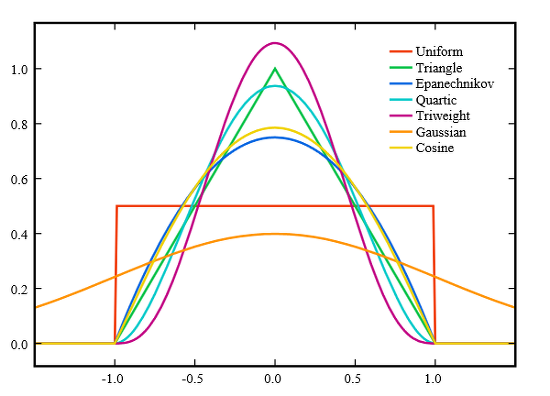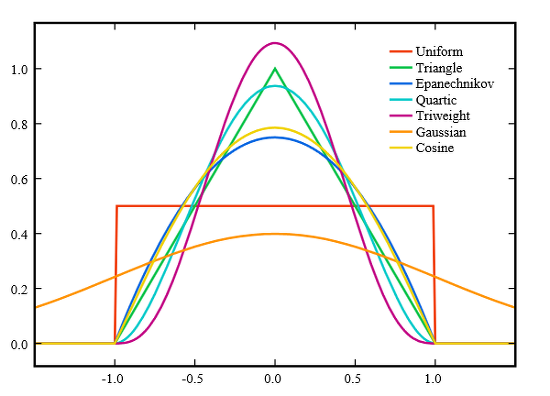  
커널함수 조건 3가지
1. 적분값이 1이다.

2. 중앙을 기준으로 대칭이다.

3. 양수값만을 가진다

참고 [링크1](https://darkpgmr.tistory.com/147) [링크2](https://hleecaster.com/python-seaborn-kdeplot/) [링크3](https://gnaseel.tistory.com/34)

In [23]:
# 나이와 개실등급에 따른 생존 확률 그려보기 

plt.figure(figsize=(8, 6))
# 위와 똑같은 KDE 그래프지만 sns가 아닌 numpy에서 연결된 plt로 그린다.
# 위으 그래프를 Survived 로 나누지 않고 Pclass(좌석등급)로 나눈다
# 그래프를 보면 1등급 객실은 나이든 사람이 많고 생존률이 낮고
# 3등급 갱실은 나이적은 사람이 많고 생존률이 높은걸 확인할 수 있따

df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

In [24]:
# 나이에 따른 생존확률의 변화율을 확인할 수 있다.
# 점점 내려가면서 순간적으로 올라간 구간은 해당 나이대에 생존확률이 높았었다고 해석할 수 있다. 
cummulate_survival_ratio = []
for i in range(1, 80):
    # 특정 나이 이하의 생존여부를 누적합 하여 해당 샘플 수 많큼 나누어 해당 구간의 생종확률을 확인한다.
    # 이를 list에 모은다.
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived'])) 
    
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

## 2.5 Pclass, Sex, Age
seabonr의 violinplot으로 Sex, Pclass, Age, Survived 4가지의 관계성을 그려본다.  

In [25]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))


sns.violinplot("Sex","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

violinplot에서 scale은 count, area, width가 있다.  
- count: 해당 데이터 수 만큼 너비를 스케일링, 데이터 수에 따른 분포를 비교 해 볼 수 있다.
- width: 각 분포의 최고확률을 같게한다, 데이터 수에 따른 차이를 없앤 분포를 볼 수 있다.
- area: 분포의 크기를 같게 한다, 데이터 수의 영향은 없애고 분산을 늘려 hue를 기준으로 분포를 비교할 수 있다.  

## 2.6 Embarked

In [26]:
# 각 탑승 정박지(Embarekd)의 평균 생존(Survived)비율을 구해본다.
# Embarked, Survived를 Embarked를 기준으로 그룹화
# 평균치를 구하고 Survived를 기준으로 정렬한다.
f, ax = plt.subplots(1,1,figsize=(7,7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

In [27]:
# Embarked를 다른 피쳐들을 기준으로 구별해 분포를 알아본다.

f,ax=plt.subplots(2, 2, figsize=(20,15))
# 1. 정박지별 탑승자 수
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
# 2. 정박지별 탑승 성별 수
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
# 3. 정박지별 생존 수 
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
# 4. 정박지별 객실 등급 수
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
# 그래프 간의 간격을 주어서 글자가 곂치지 않게한다
plt.subplots_adjust(wspace=0.2, hspace=0.5) 
plt.show()

## 2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)

In [28]:
# SibSp, Parch는 모두 가족으로 통합시킬 수 있으므로 Family로 만든다.
# 마지막 +1은 자신을 포함시키기 위함
# train,test셋 모두 동일한 피쳐를 만든다.
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1

In [29]:
# 생성된 FamilySize의 최소인원 최대인원 확인
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

In [30]:
# 가족인원 별 생존관련 그래프를 그려본다.
# 같이 탑승한 가족이 2~4명일 경우의 생존률이 높다.
# 혼자일 경우 도와줄 사람이 없거나
# 많을 경우 모두를 구하기가 어려웠을것으로 예상된다.

f,ax=plt.subplots(1, 3, figsize=(40,10))
# 1.가족인원 수 그려보기
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)
# 2.가족인원 수에 따른 생존여부 그려보기
sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)
# 3.가족인원 수에 따른 생존율 극려보기
# FamilySize, Survived를 FamilySize 기준으로 그룹화
# 평균치를 구하고 Survived를 기준으로 정렬한다.
df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## 2.8 Fare
Fare는 탑승요금을 뜻하고 연속형 변수이다.  

### 첨도와 왜도
첨도(Kurtosis) : 분포가 얼마나 쬬족, 분산이 얼마나 작은지  
왜도(Skewness) : 분포의 좌우측 쏠림 정도, 평균값의 위치가 어딘지  
                 0보다 크면 좌측, 0보다 작으면 우측으로 치우침  
                 

In [31]:
# Fare의 분포를 그리면서 첨도(Skewness)까지 계산해서 넣는다.

fig,ax = plt.subplots(1,1,figsize=(8,8))
# distplot 으로 Fare의 분포도를 그린다
# label에 skewness를 넣으면서 DataFrame타입에서 제공하는 skew()를 사용해서 계산한다.
# skenwss가 0보다 큰 4.79로 나오면서 좌측으로 쏠림을 알 수 있다.
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

Fare데이터셋의 skewness가 0에 가깝지 않고 한쪽으로 치우쳐저 있기 때문에  
데이터셋의 불균형이 있다고 볼 수 있다.  
데이터셋의 imbalance는 모델이 학습할떄 해당 데이터셋에 대해 편향되어 학습할 수 있기 때문에  
skeness를 없애는 `__피쳐 엔지니어링__`이 필요하다.  
여기서는 log를 적용해본다.  

> 요금없이 탄 사람들도 있다고 한다.  
해당 인원은 추가로 처리할 필요가 있어보인다.

In [32]:
# log를 적용하여 Fare데이터셋의 치우쳐진 분포를 정규분포에 가깝게 수정한다. 
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

### 커스텀 함수를 적용하는 방법들 (map, apply, applymap)
참고 [링크](http://www.leejungmin.org/post/2018/04/21/pandas_apply_and_map/)  
- map : Series타입에만 적용, 단일 컬럼에 사용
- apply : 커스텀 함수에 복수의 컬럼이 필요시 사용
- applymap : apply처럼 컬렴별이 아닌 element별로 커스텀 함수를 적용시 사용

In [33]:
# 다시 그려본다.
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

## 2.9 Cabin
초기에 결측치 확인을 했을떄 80%에 가깝게 없었으므로 Cabin 피쳐는 안쓰기로 한다.  
여기선 넘어가고 나중에 지운다.  

## 2.10 Ticket
string형 데이터이고 각 데이터의 형식과 길이가 달라서 세세한 피쳐 엔지니어링이 필요하다.  
정규표현식을 사용해서 뒷부분의 숫자와 앞부분의 문자를 분리할 수 있을것 같다.  
또는 티켓번호는 객실좌석과 객실등급의 정보를 가지고 있는 Pclass와 연관이 있으므로 사용하지 않아도 문제 없을 수 있다.  

# 3. Feature Engineering
## 3.1 Null 데이터(결측치) 채우기
lightgbm같은 null데이터를 무시하고 학습하는 모델도 있지만 결측치 채우기를 해본다.  
결측치를 채우면 해당 피쳐의 분포를 좌지우지 할 수 있기 때문에 주의깊게 해야 한다.  

In [34]:
# 초반의 데이터셋 null값 확인을 다시 해본다.
for col in df_test.columns:
    # format을 통해 변수를 어떤 규격으로 출력할지 결정
    # {:>11} : 11칸을 만들고 우측(>)으로 정렬 한다.
    # https://pyformat.info/#string_pad_align
    # 수식은 null값 수/전체 수 를 퍼센트로 표현하기 위함
    msg = 'column: {:>11}\t Percernt of NaN value: {:2f}%'.format(col, 100*(df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

### 3.1.1. Fill Null in Age using title
Cabin은 안쓰기로 했으니 Age의 결측치를 먼저 채워본다.  


In [35]:
df_train['Name']

 Name을 보면 Mr,Mrs등의 타이틀이 있는 경우가 많다.  
 이런 타이틀을 구분해서 어떤 타이틀들이 있나 확인해 본다.  
 각 타이틀들을 Master, Miss, Mr, Mrs 4가지로만 재분류 해서  
 해당 그룹의 Age 평균값을 사용해 결측치를 채워보기로 한다.  

In [36]:
# 모든 타이틀은 (.)마침표 앞에 따라 온다. 그래서 정규표현식을 사용해서 추출한다.  
# Name을 str 타입으로 변경하고
# extract에 정규표현식을 넣어서 타이틀을 추출한다. 
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.')     
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') 

In [37]:
# 모든 타이틀의 성별을 확인한다. 
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

In [38]:
# 모든 타이틀을 성별을 쉽게 알아볼 수 있게 Mr,Mrs,Miss 3가지로 분류해 변경한다.  
# replace의 첫번째인자는 변경될 타이틀
# 두번째 인자는 변경후 타이틀
# 세번째 인자는 교체 유무를 결정해 주는 inplace=True 를 넣는다. 꼭 True를 해야만 변경된다.
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [39]:
# 수정된 Inital들의 다른 피쳐들간의 기본통계를 출력해 본다. 
df_train.groupby('Initial').mean()

In [40]:
# 타이틀 별 생존률을 그려본다.  
df_train.groupby('Initial')['Survived'].mean().plot.bar()

train,test의 null값을 채우는 방법?  
test는 모르는 상황에 대한 정보이므로  
train의 분포정보를 가지고 test의 null을 채우면 안된다.  
그러므로 test셋은 별도의 Initial 컬럼을 만들어 평균값을 구한후 채워야 한다.  

In [41]:
# train,test 모두 각 타이틀의 평균값을 대체해서 넣는다.
# AND 연산으로 null값을 가지고 Initial 조건이 맞으면 
# 위에서 구한 평균값을 넣어준다. 평균값은 반올림해서 직접 입력해 준다.

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked


In [42]:
df_train['Embarked'].isnull().sum()

결측치가 2개밖에 없고 S에서 가장 탑승한 승객이 많았으므로 S로 채워도 문제 없어보인다.  

In [43]:
df_train['Embarked'].fillna('S', inplace=True)

In [44]:
df_train['Embarked'].isnull().sum()

## 3.2 Change Age (Continous to Categorical)
연속정보가 이산적인 정보로 변환되다 보니 모든 값이 표현되지 않아 정보손실이 일어날 수 있다.  
기존의 Age(나이)는 __모든 나이구간__을 표현하고 있지만 새로운 Age_cat을 만들어 __10살 간격의 연령대__를 생성해 본다.  
이를 하는 이유는 다양한 방법을 체험해 보기 위함이다.  

방법 2가지가 있다.
1. DataFrame의 loc으로 하는 방법
2. apply를 이용해 함수를 사용하는 방법 (이게 더 편하긴 하다ㅋㅋㅋ)

둘다 다음과 같이 분류한다.  
10\~20 일 경우 1  
20\~30 일 경우 2  
30\~40 일 경우 3  
40\~50 일 경우 4  
50\~60 일 경우 5  
60\~70 일 경우 6  
70이상 일 경우 7  


### 1. loc을 이용한 방법

In [45]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

In [46]:
df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

### 2. apply를 이용한 방법

In [47]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    

In [48]:
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [49]:
# 두가지 방법의 결과를 비교한다
# all() 모든게 True일 경우 True
# any() 하나라도 True일 경우 True
(df_train['Age_cat'] == df_train['Age_cat_2']).all()

In [50]:
# Age_cat외에 다 필요 없기 떄문에 지운다
# test에서 Age_cat_2를 생성하진 않았기 때문에 지우진 않는다.
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3. Change Initial, Embarked and Sex (string to numerical)
3가지 피쳐는 string(문자열)로 되어 있는데 그대로 사용될 순 없다.  
모델의 학습은 수학의 연산과정으로 이루어져 있기에 적절한 숫자로 변경 되어야 한다.  


숫자가 되면 순서정보가 있을 수 있는데 이를 제거해야 할 경우?

### Initial 피쳐 변경

In [51]:
# Initial 의 카테고리 종류 확인
df_train['Initial'].unique()

In [52]:
# map을 사용하여 각 카테고리에 숫자를 부여한다.
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

### Embarked 피쳐 변경

In [53]:
# Embarked의 카테고리와 갯수 확인
df_train['Embarked'].value_counts()

In [54]:
# Embarked의 각 카테고리에 숫자 부여
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [55]:
# Embarked의 변경된 카테고리와 갯수 확인
df_train['Embarked'].value_counts()

In [56]:
# 결측치 재확인
df_train['Embarked'].isnull().sum()

### Sex 피쳐 변경

In [57]:
df_train['Sex'].value_counts()

In [58]:
# 각 성별 숫자로 변경
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

In [59]:
df_train['Sex'].value_counts()

### 각 피쳐의 상관관계를 확인해 본다
Pearson Correlation을 많이 사용하며  
-1에 가까울 수록 음의 상관관계  
+1에 가까울 수록 양의 상관관계를 가진다.  
Pearson 에사용 되는 수식은 아래와 같다.  
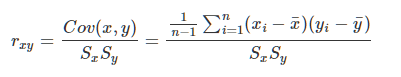  

In [60]:
# 상관관계를 그릴 히트맵에 사용될 피쳐만 선택하기
heatmap_data = df_train[['Survived', 'Pclass','Sex','Fare','Embarked','FamilySize','Initial','Age_cat']]
heatmap_data.corr()

In [61]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,10))
plt.title("Pearson Correalation of Features", y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":16})

# 사용끝난 데이터 삭제
del heatmap_data

상관관계맵으로 부터....
- 전체적으로 큰 상관계수를 가지는 피쳐들이 없음을 볼 수 있다. 이는 학습을 진행할때 불필요한(redundant, superfluous)한 피쳐가 없다는 것을 의미한다. 만약 높은 상관계수를 가지는 피쳐들이 있다면 해당 피쳐들로부터 얻을 수 있는 정보는 같을 것이라고 볼 수 있다.
- Survived에 대한 Pclass와 Sex의 상관관계가 크다는 것은 해당 피쳐들이 Survived에 개입하는 정도가 크다고 볼 수 있다.
- Initial과 Age_cat간의 상관관계가 높은것은 Age_cat으로 변경하기 전 Age의 결측치를 Initial에 기반하여 채웠기 때문이라고 볼 수 있을 것 같다. 

# 3.4 One-hot encoding on Initial and Embarked
- Initial과  Embarked를 numeric으로 변경 했지만 불필요한 순서정보가 있을 수 있다.
- Initial의 어떤 타이틀이 먼저인가 보단 해당 타이틀에 해당하냐가 더 중요하다.
- 그러므로 one-hot encoding으로 변경하여 해당 카테고리에 대한 유무를 피쳐로 만들어 버릴 수 있다.

주의점
- 카테고리가 너무 많으면 카테고리 종류 만큼 컬럼이 생성된다.

In [62]:
# Initial에 대하여 원핫인코딩
# pandas에서 제공하는 dummies를 사용하여 원하인코딩
# prefix는 생성될 컬럼의 접미사에 붙일 내
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')
df_train.info()

In [63]:
# Embarked에 대하여 원핫인코딩
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')
df_train.info()

## 3.5 Drop Columns
필요한 컬럼만 뺴고 모두 지운다.

In [64]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_train.info()

# 4. Building Model and Predict


In [65]:
# Survived의 유무를 찾는 분류 문제이기 때문애 Classifier 사용
from sklearn.ensemble import RandomForestClassifier
# 모델 평가 방법
from sklearn import metrics
# 데이터셋 분리 모듈
from sklearn.model_selection import train_test_split

## 4.1 Preparation - Split dataset into train, valid, test set

In [66]:
# 피쳐 엔지니어링이 완료된 데이터셋으로 별도의 인스턴스 생성
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [67]:
# X_train을 train,valid셋으로 분리
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

## 4.2 Model generation and prediction

In [68]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)

In [70]:
prediction = model.predict(X_vld)
prediction

In [71]:
# 학습한 모델을 valid셋으로 평가 해 accuracy를 알아본다
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

## 4.3 Feature importance 
- 학습된 모델은 feature importance를 가지게 된다.
- feature importance 는 어느 피쳐가 모델에 가장 많은 영향을 끼쳤는지 보여준다.
- model의 feature_importance_ 객체를 불러서 확인 할 수 있다.

In [72]:
model.feature_importances_

- Series로 변환해서 Sorting하여 그래프로 그려본다

In [74]:
from pandas import Series
feature_importance = model.feature_importances_
# Series 타입으로 변환
Series_feat_imp = Series(feature_importance, index=df_test.columns)

In [75]:
plt.figure(figsize=(8, 8))
# ascending순으로 정렬하고
# 수평 바그래프(barh)로 그려본다
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- fare가 상당히 큰 영향을 주는 것을 알 수 있다.
- 원핫 인코딩으로 생성된 피쳐중 Inital_2빼곤 모두 별 영향이 없다.
- 그래프를 보고 영향력이 적은 피쳐는 제거하고 재학습을 시켜서 정확도를 높일 수 도 있다.

## 4.4 Prediction on Test set 
- test셋을 이용해서 예측값을 만들어 본다.
- 만들어진 예측값을 submission(제출용) 파일로 만들어서서 캐글에 제출해 본다.

In [77]:
# test셋의 prediction이 들어갈 파일을 불러온다
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [78]:
submission.head()

In [80]:
# X_test로 예측을 하고 
# submission파일의 Survived컬럼을 예측값으로 변경한
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [82]:
submission.to_csv('./my_first_submission.csv', index=False)

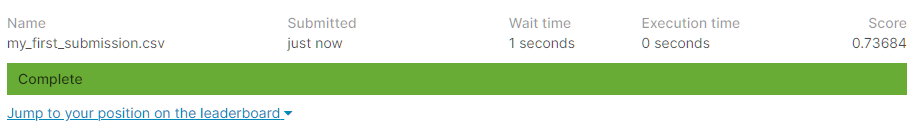